# Planet: Understanding the Amazon deforestation from Space challenge

Special thanks to the kernel contributors of this challenge (especially @anokas and @Kaggoo) who helped me find a starting point for this notebook.

The whole code including the `data_helper.py` and `keras_helper.py` files are available on github [here](https://github.com/EKami/planet-amazon-deforestation) and the notebook can be found on the same github [here](https://github.com/EKami/planet-amazon-deforestation/blob/master/notebooks/amazon_forest_notebook.ipynb)

**If you found this notebook useful some upvotes would be greatly appreciated! :) **

Start by adding the helper files to the python path

In [1]:
import sys

sys.path.append('/home/ubuntu/kaggle/src')
sys.path.append('/home/ubuntu/kaggle/test')
sys.path.append('/home/ubuntu/data/input')

## Import required modules

In [27]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import data_helper
from keras_helper import AmazonKerasClassifier

from itertools import chain

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Inspect image labels
Visualize what the training set looks like

In [13]:
train_jpeg_dir, test_jpeg_dir, test_jpeg_additional, train_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Each image can be tagged with multiple tags, lets list all uniques tags

In [15]:
# Print all unique tags
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'water', 'primary', 'agriculture', 'road', 'partly_cloudy', 'bare_ground', 'artisinal_mine', 'selective_logging', 'blow_down', 'haze', 'cultivation', 'habitation', 'cloudy', 'conventional_mine', 'clear', 'blooming', 'slash_burn'}


### Repartition of each labels

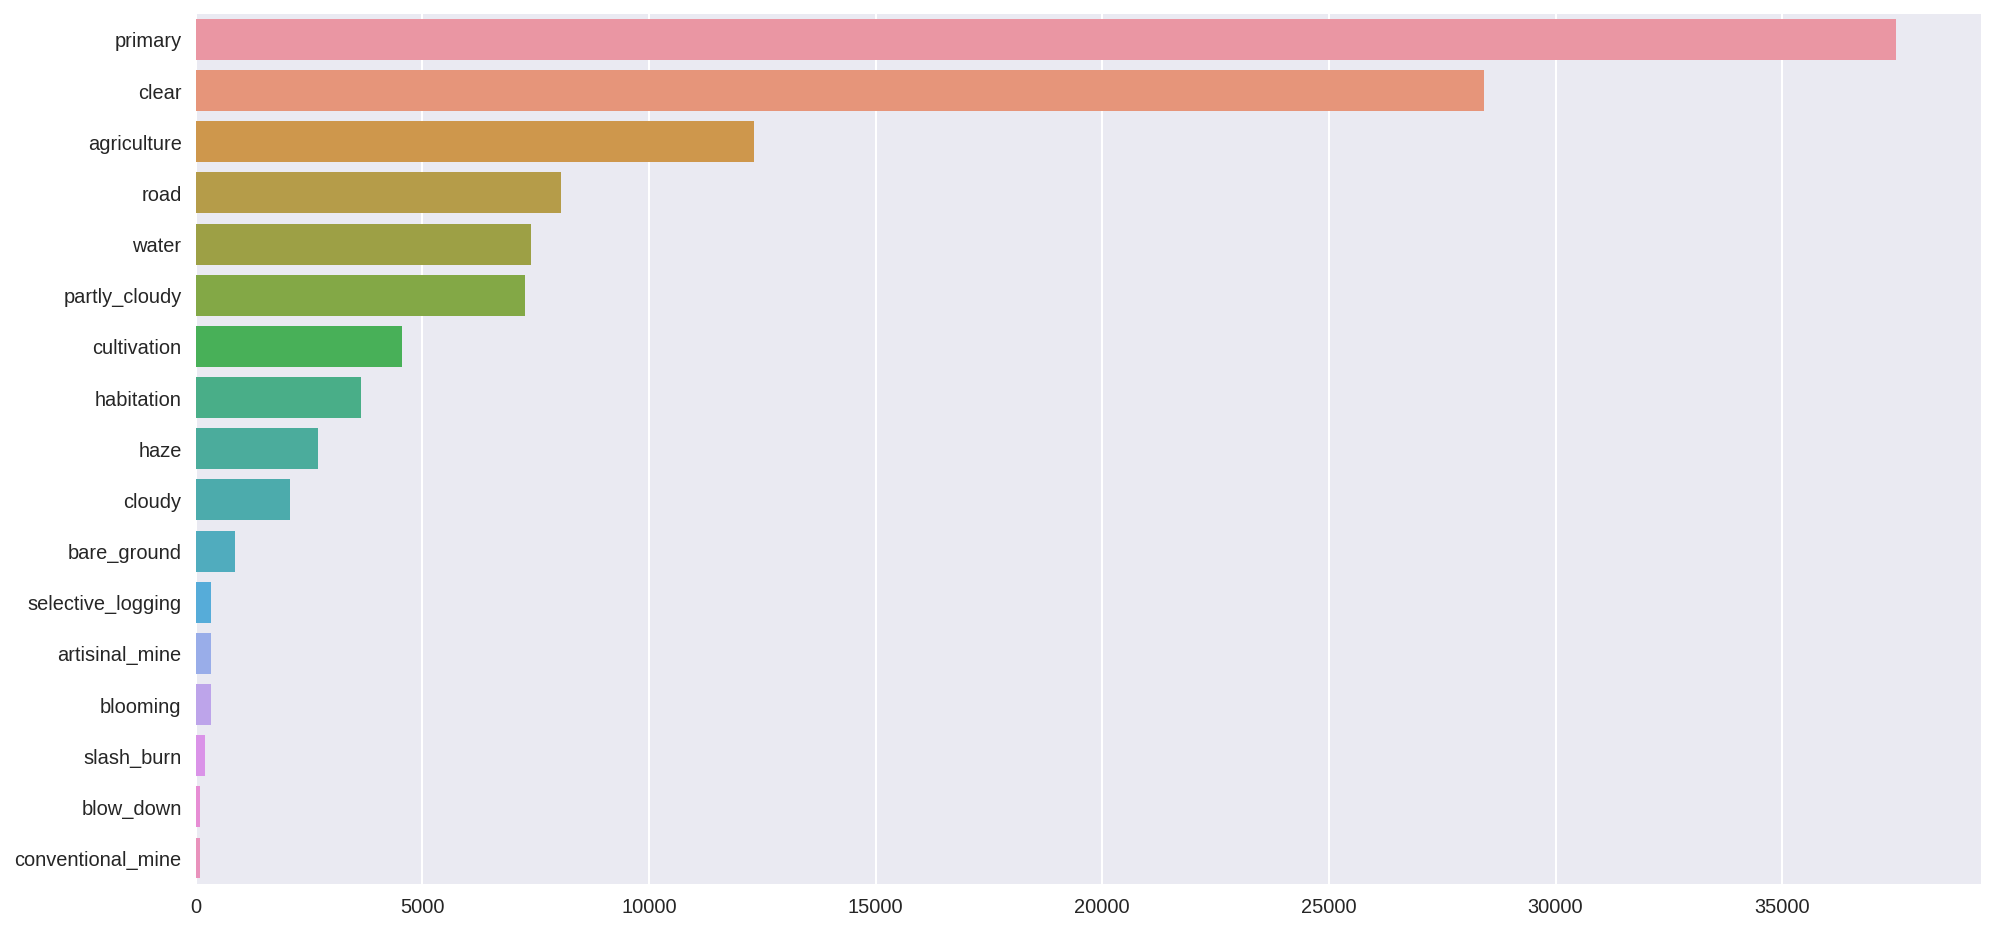

In [17]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

## Images
Visualize some chip images to know what we are dealing with.
Lets vizualise 1 chip for the 17 images to get a sense of their differences.

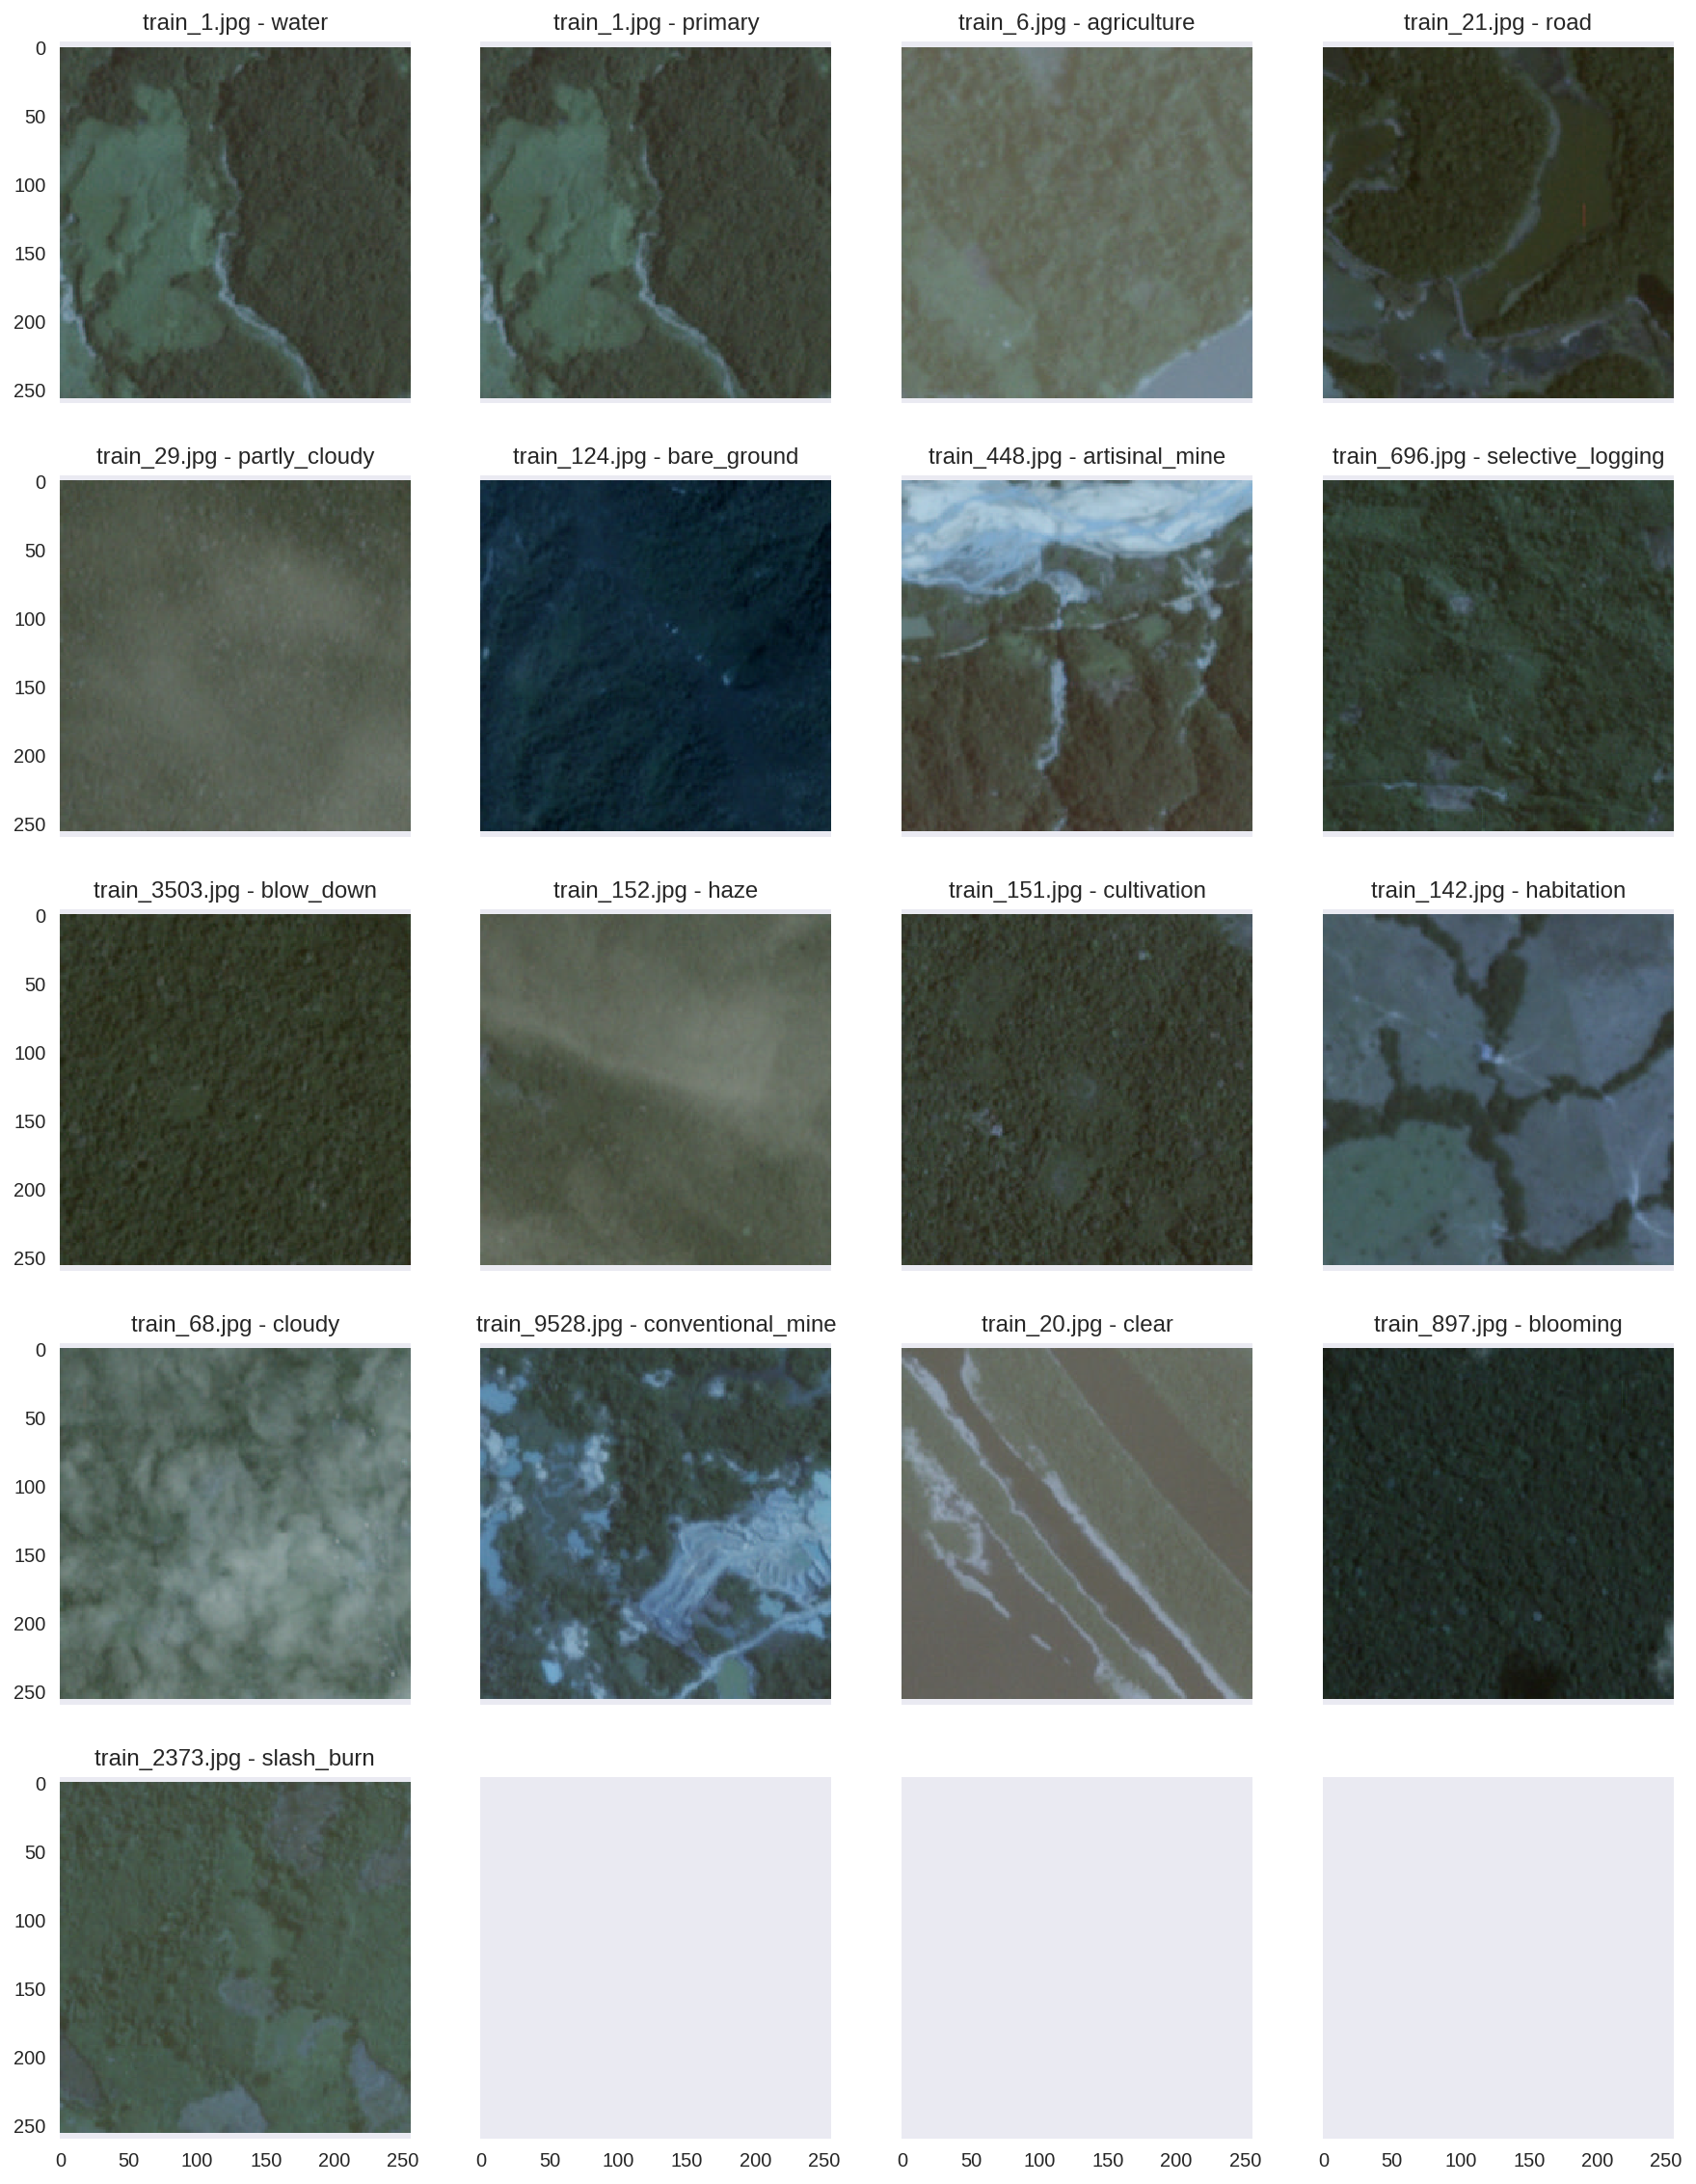

In [22]:
images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = cv2.imread(train_jpeg_dir + '/' + image_name, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

# Define hyperparameters
Define the hyperparameters of our neural network

In [23]:
img_resize = (64, 64) #The resize size of each image
validation_split_size = 0.2
epochs = 20
batch_size = 128

# Data preprocessing
Preprocess the data in order to fit it into the Keras model.

Due to the hudge amount of memory the resulting matrices will take, the preprocessing will be splitted into several steps:
    - Preprocess training data (images and labels) and train the neural net with it
    - Delete the training data and call the gc to free up memory
    - Preprocess the first testing set
    - Predict the first testing set labels
    - Delete the first testing set
    - Preprocess the second testing set
    - Predict the second testing set labels and append them to the first testing set
    - Delete the second testing set

In [24]:
x_train, y_train, y_map = data_helper.preprocess_train_data(train_jpeg_dir, train_csv_file, img_resize)
# Free up all available memory space after this heavy operation
gc.collect();

Transforming train data to matrices. Using 8 threads...


100%|██████████| 40479/40479 [00:21<00:00, 1849.69it/s]


Done. Size consumed by arrays 1898.1093893051147 mb


In [25]:
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
y_map

x_train shape: (40479, 64, 64, 3)
y_train shape: (40479, 17)


{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

## the neural network definition

In [30]:
classifire = AmazonKerasClassifier()
classifire.add_conv_layer(img_resize)
classifire.add_flatten_layer()
classifire.add_ann_layer(len(y_map))
train_losses, val_losses, fbeta_score = classifire.train_model(x_train, y_train, epochs, batch_size, validation_split_size=validation_split_size)

Train on 32383 samples, validate on 8096 samples
Epoch 1/20
32383/32383 [==============================] - 143s - loss: 0.2219 - acc: 0.9091 - val_loss: 0.2399 - val_acc: 0.9237
Epoch 2/20
32383/32383 [==============================] - 142s - loss: 0.1824 - acc: 0.9272 - val_loss: 0.1740 - val_acc: 0.9330
Epoch 3/20
32383/32383 [==============================] - 142s - loss: 0.1699 - acc: 0.9323 - val_loss: 0.1642 - val_acc: 0.9347
Epoch 4/20
32383/32383 [==============================] - 142s - loss: 0.1601 - acc: 0.9365 - val_loss: 0.1525 - val_acc: 0.9404
Epoch 5/20
32383/32383 [==============================] - 142s - loss: 0.1542 - acc: 0.9392 - val_loss: 0.1447 - val_acc: 0.9432
Epoch 6/20
32383/32383 [==============================] - 142s - loss: 0.1506 - acc: 0.9409 - val_loss: 0.1422 - val_acc: 0.9438
Epoch 7/20
32383/32383 [==============================] - 143s - loss: 0.1469 - acc: 0.9425 - val_loss: 0.1395 - val_acc: 0.9455
Epoch 8/20
32383/32383 [========================

## Monitor the results

Check that we do not overfit by plotting the losses of the train and validation sets

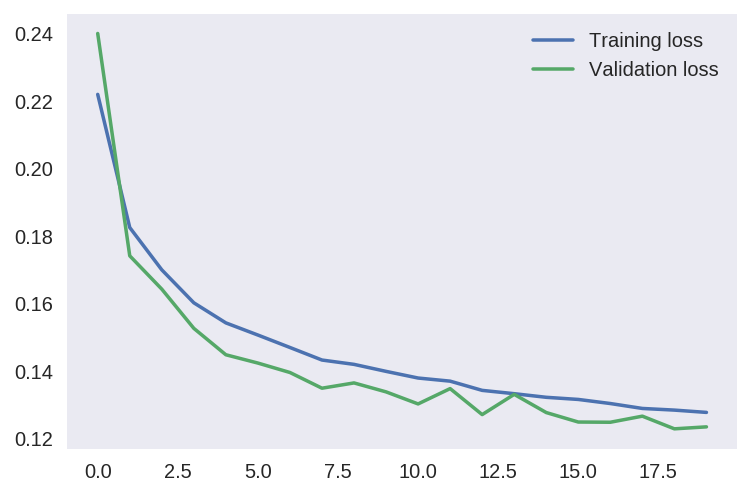

In [31]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend();

Look at our fbeta_score

In [37]:
fbeta_score

0.88892741699089017

Before launching our predictions lets preprocess the test data and delete the old training data matrices

In [39]:
del x_train, y_train
gc.collect()

x_test, x_test_filename = data_helper.preprocess_test_data(test_jpeg_dir, img_resize)
# Predict the labels of our x_test images
predictions = classifire.predict(x_test)

100%|██████████| 40669/40669 [00:17<00:00, 2321.38it/s]


Done. Size consumed by arrays 1906.359375 mb


Now lets launch the predictions on the additionnal dataset (updated on 05/05/2017 on Kaggle)

In [40]:
del x_test
gc.collect()

x_test, x_test_filename_additional = data_helper.preprocess_test_data(test_jpeg_additional, img_resize)
new_predictions = classifire.predict(x_test)

del x_test
gc.collect()
predictions = np.vstack((predictions, new_predictions))
x_test_filename = np.hstack((x_test_filename, x_test_filename_additional))
print("Predictions shape: {}\nFile name shape: {}\nlst predictions entry:\n{}".format(predictions.shape, x_test_filename.shape, predictions[0]))

100%|██████████| 20522/20522 [00:07<00:00, 2591.52it/s]


Done. Size consumed by arrays 961.96875 mb
Predictions shape: (61191, 17)
File name shape: (61191,)
lst predictions entry:
[  9.60572660e-01   1.52006850e-03   3.42853032e-02   5.16305408e-05
   1.44573278e-04   9.26238418e-01   2.66887564e-05   3.44602205e-03
   2.00298980e-01   3.85753185e-01   3.05913165e-02   5.44573292e-02
   9.65001225e-01   7.94070840e-01   1.07908912e-03   8.54376983e-03
   2.09514827e-01]


Before mapping our predictions to their appropriate labels we need to figure out what threshold to take for each class.

To do so we will take the median value of each classes.

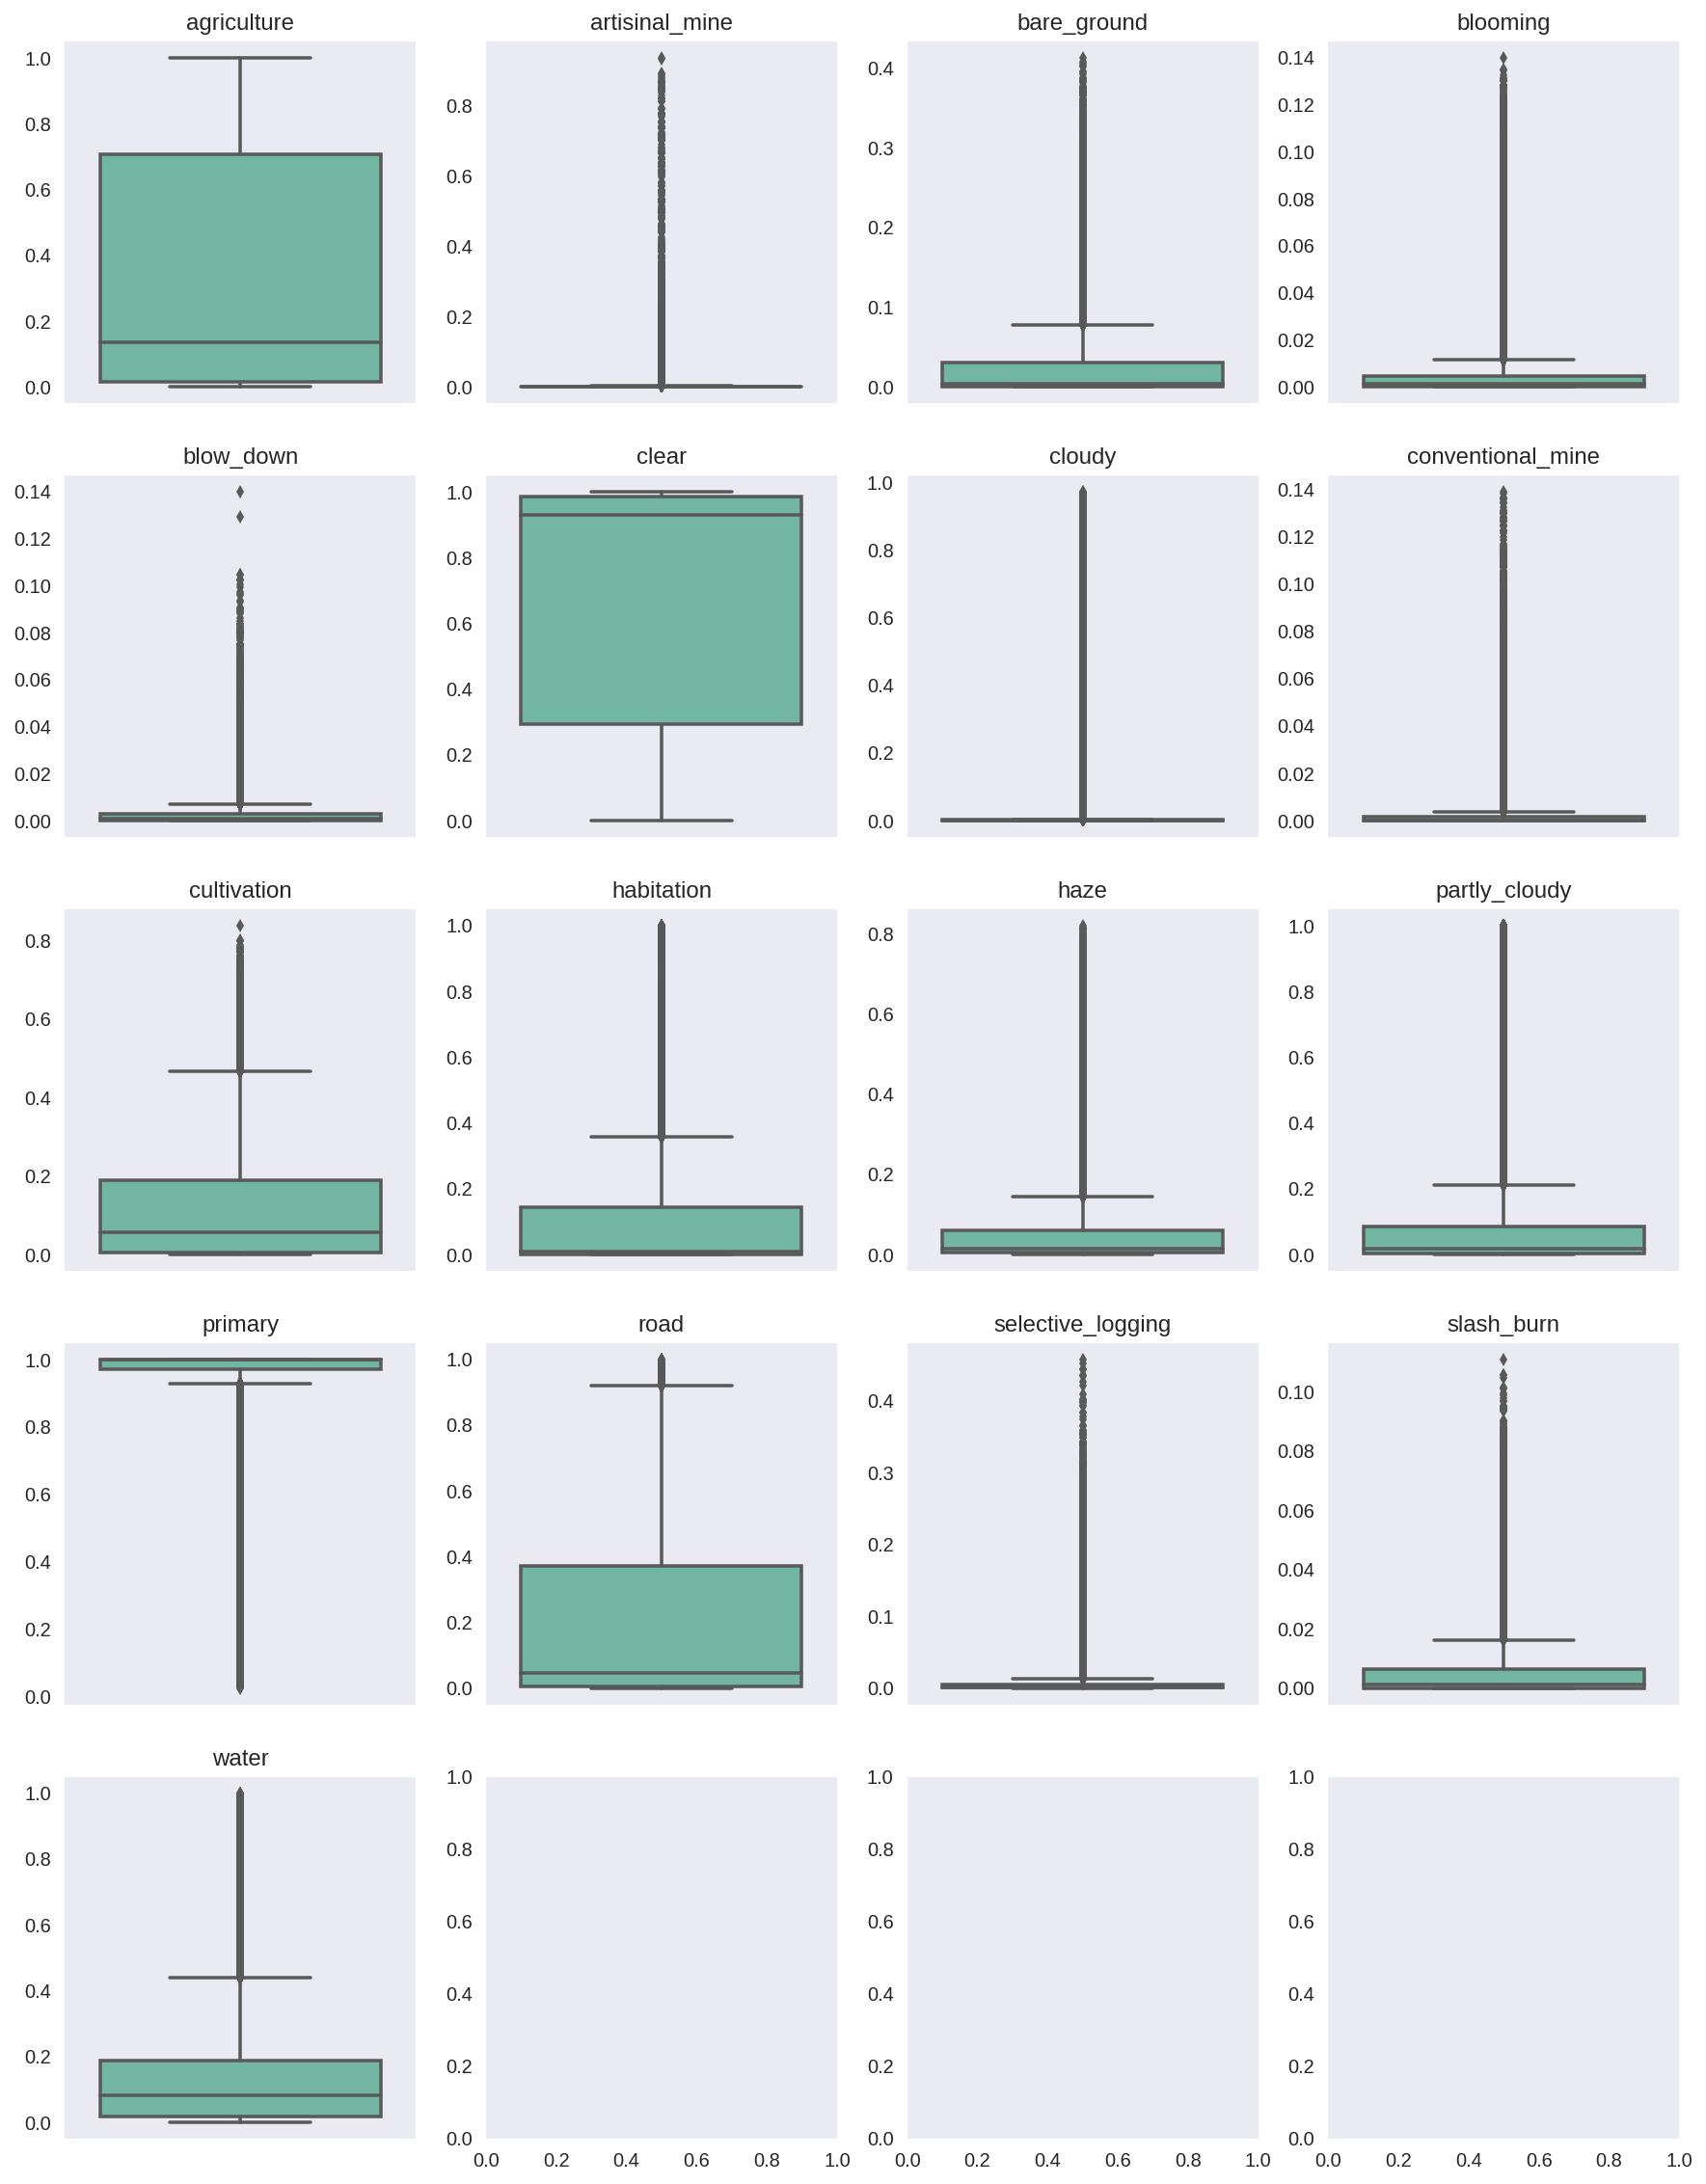

In [42]:
# For now we'll just put all thresholds to 0.2 
thresholds = [0.2] * len(labels_set)

#TODO complete
tags_pred = np.array(predictions).T
_, axs = plt.subplots(5, 4, figsize=(15, 20))
axs = axs.ravel()

for i, tag_vals in enumerate(tags_pred):
    sns.boxplot(tag_vals, orient='v', palette='Set2', ax=axs[i]).set_title(y_map[i])

Now lets map our predictions to their tags and use the thresholds we just retrieved

In [43]:
predicted_labels = classifire.map_predictions(predictions, y_map, thresholds)

Finally lets assemble and visualize our prediction for the test dataset

In [46]:
tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]

In [48]:
final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
final_df.head()

,image_name,tags
0,test_3555,agriculture clear cultivation habitation prima...
1,test_19235,partly_cloudy primary
2,test_29222,agriculture clear cultivation habitation prima...
3,test_21758,clear primary
4,test_17310,agriculture clear cloudy primary water


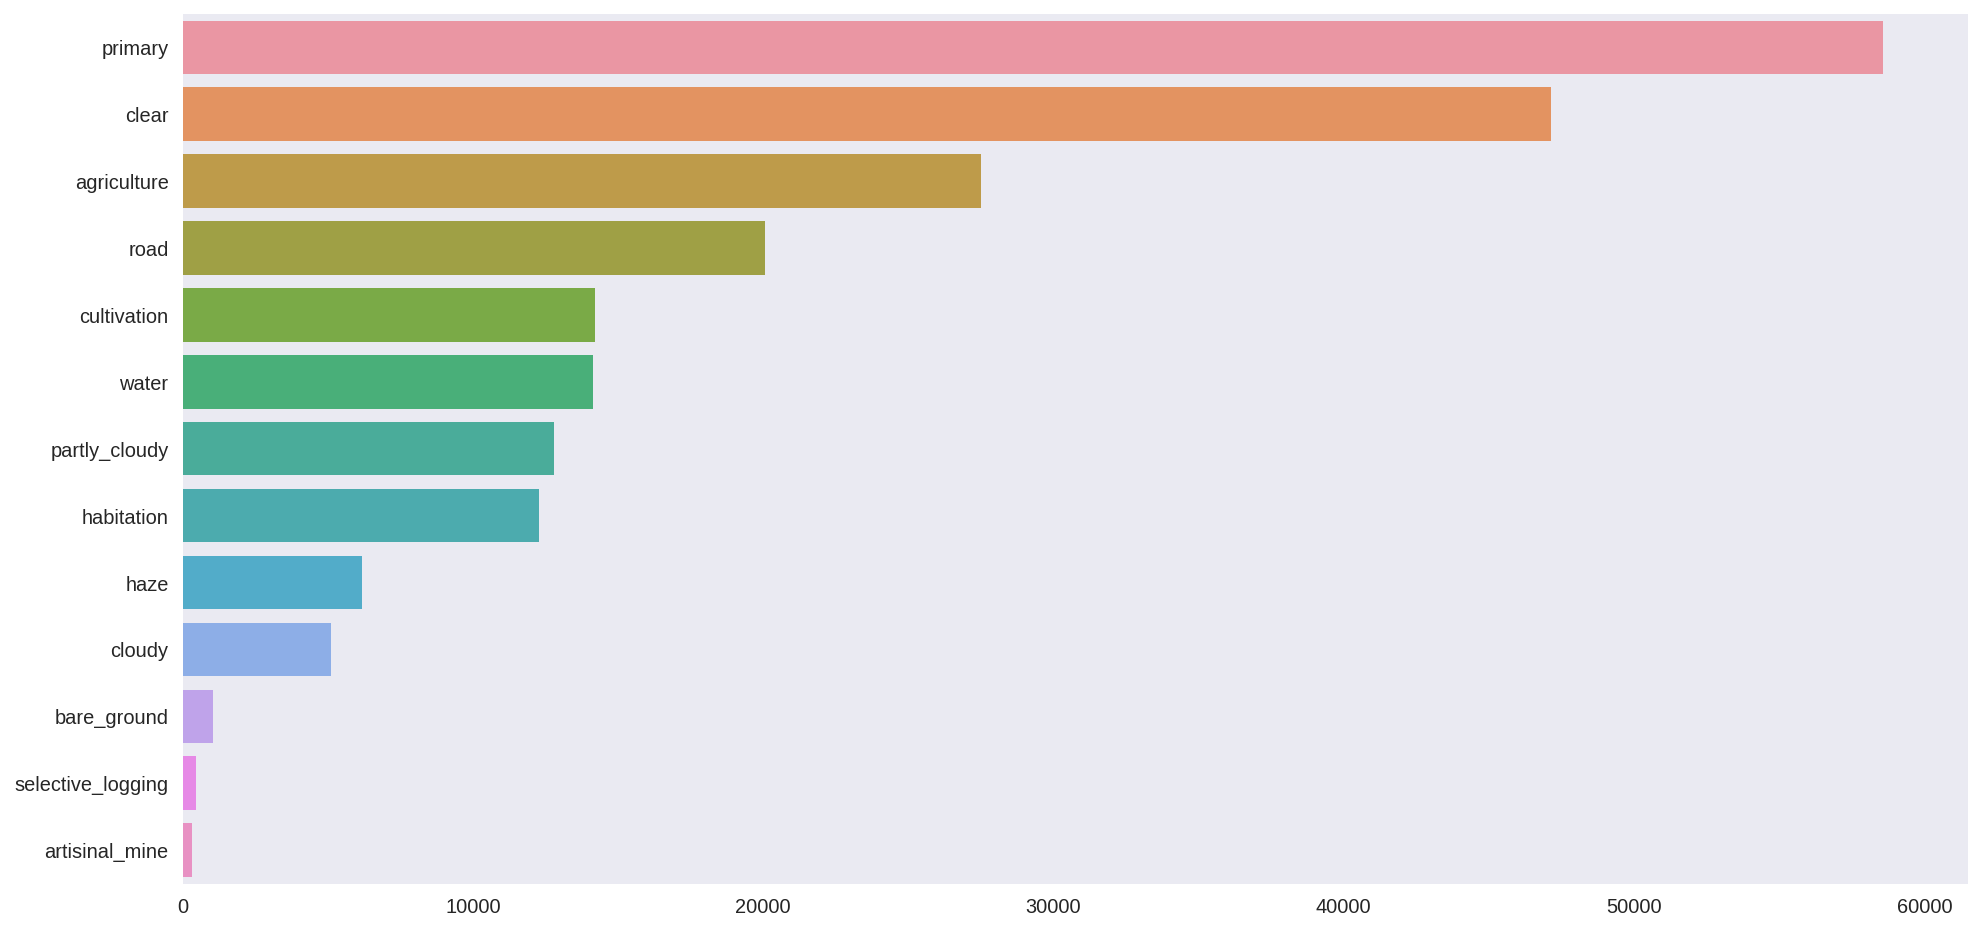

In [50]:
tags_s = pd.Series(list(chain.from_iterable(predicted_labels))).value_counts()
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=tags_s, y=tags_s.index, orient='h');

In [51]:
final_df.to_csv('/home/ubuntu/kaggle/submission_file.csv', index=False)
classifier.close()

NameError: name 'classifier' is not defined